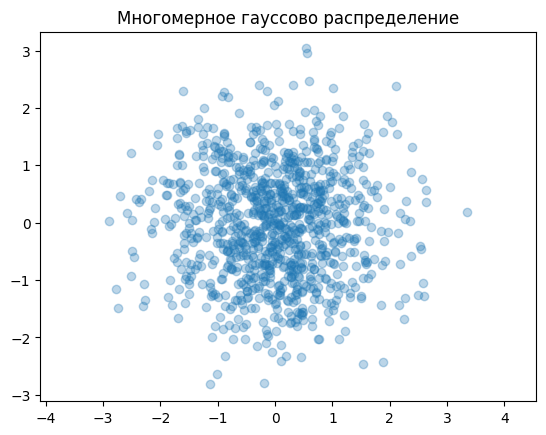

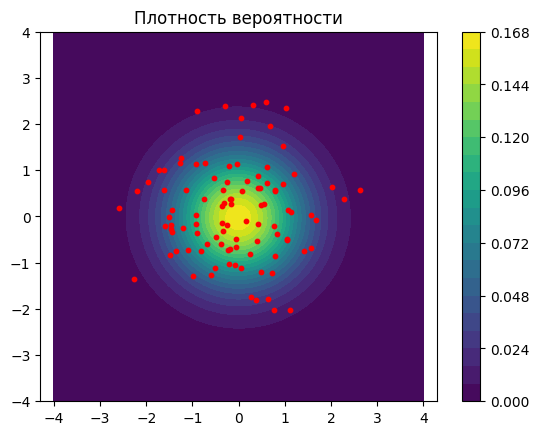

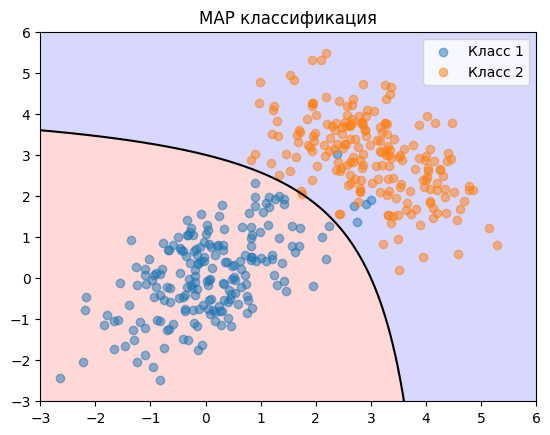

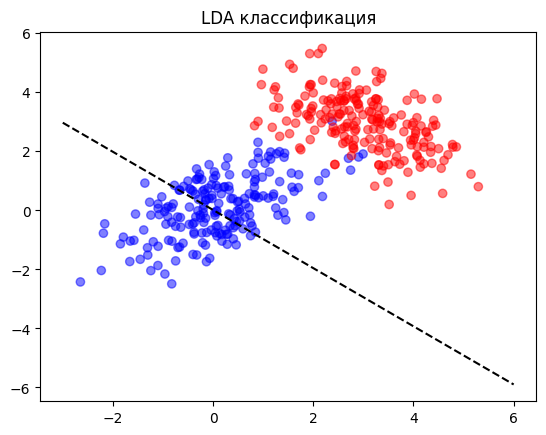

LDA:
Accuracy: 0.9416666666666667
Precision: 0.8923076923076924
Recall: 1.0

Naive Bayes:
Accuracy: 0.9416666666666667
Precision: 0.8923076923076924
Recall: 1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# 1. Многомерное гауссово распределение
np.random.seed(0)
x = np.random.normal(size=(1000, 2))
theta = np.pi / 4
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
x_rot = x @ R.T

mu = np.mean(x_rot, axis=0)
C = np.cov(x_rot.T)

plt.scatter(x_rot[:,0], x_rot[:,1], alpha=0.3)
plt.title("Многомерное гауссово распределение")
plt.axis("equal")
plt.show()

# 2. Плотность вероятности Гаусса
X, Y = np.meshgrid(np.linspace(-4,4,100), np.linspace(-4,4,100))
pos = np.dstack((X, Y))
rv = multivariate_normal(mean=mu, cov=C)
Z = rv.pdf(pos)

plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.scatter(x_rot[:100,0], x_rot[:100,1], c='red', s=10)
plt.title("Плотность вероятности")
plt.axis("equal")
plt.show()

# 3. MAP классификация для 2 классов
mean1 = [0, 0]; cov1 = [[1, 0.5],[0.5, 1]]
mean2 = [3, 3]; cov2 = [[1, -0.5],[-0.5, 1]]

x1 = np.random.multivariate_normal(mean1, cov1, 200)
x2 = np.random.multivariate_normal(mean2, cov2, 200)

priors = [0.5, 0.5]

X, Y = np.meshgrid(np.linspace(-3,6,200), np.linspace(-3,6,200))
pos = np.dstack((X, Y))

rv1 = multivariate_normal(mean1, cov1)
rv2 = multivariate_normal(mean2, cov2)

Z1 = rv1.pdf(pos) * priors[0]
Z2 = rv2.pdf(pos) * priors[1]

plt.contourf(X, Y, Z1 > Z2, alpha=0.3, cmap="bwr")
plt.scatter(x1[:,0], x1[:,1], label="Класс 1", alpha=0.5)
plt.scatter(x2[:,0], x2[:,1], label="Класс 2", alpha=0.5)
plt.contour(X, Y, Z1-Z2, levels=[0], colors='k')
plt.legend()
plt.title("MAP классификация")
plt.show()

# 4. LDA
class myLDA(BaseEstimator):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.means_ = {}
        self.cov_ = np.cov(X.T)
        self.cov_inv_ = np.linalg.inv(self.cov_)
        for c in self.classes_:
            self.means_[c] = X[y==c].mean(axis=0)
        return self

    def predict(self, X):
        preds = []
        for x in X:
            scores = []
            for c in self.classes_:
                mu = self.means_[c]
                score = x @ self.cov_inv_ @ mu - 0.5 * mu @ self.cov_inv_ @ mu
                scores.append(score)
            preds.append(self.classes_[np.argmax(scores)])
        return np.array(preds)

X_all = np.vstack((x1, x2))
y_all = np.array([0]*len(x1) + [1]*len(x2))

lda = myLDA().fit(X_all, y_all)

plt.scatter(X_all[:,0], X_all[:,1], c=y_all, cmap="bwr", alpha=0.5)
Xline = np.linspace(-3,6,100)
Yline = -(lda.cov_inv_[0,0]*(Xline-lda.means_[0][0]) + lda.cov_inv_[0,1]*(0-lda.means_[0][1])) / lda.cov_inv_[1,1]
plt.plot(Xline, Yline, 'k--')
plt.title("LDA классификация")
plt.show()

# 5. Naive Bayes
class myNB(BaseEstimator):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.means_ = {}
        self.vars_ = {}
        self.priors_ = {}
        for c in self.classes_:
            Xc = X[y==c]
            self.means_[c] = Xc.mean(axis=0)
            self.vars_[c] = Xc.var(axis=0)
            self.priors_[c] = len(Xc)/len(X)
        return self

    def _pdf_1d(self, x, mu, var):
        coef = 1.0/np.sqrt(2*np.pi*var)
        expo = np.exp(-(x-mu)**2/(2*var))
        return coef*expo

    def predict(self, X):
        preds = []
        for x in X:
            post = []
            for c in self.classes_:
                p_x_given_c = np.prod(self._pdf_1d(x, self.means_[c], self.vars_[c]))
                post.append(p_x_given_c * self.priors_[c])
            preds.append(self.classes_[np.argmax(post)])
        return np.array(preds)

# 6. Сравнение LDA и NB
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

lda = myLDA().fit(X_train, y_train)
nb = myNB().fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)
y_pred_nb = nb.predict(X_test)

print("LDA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lda))
print("Precision:", precision_score(y_test, y_pred_lda))
print("Recall:", recall_score(y_test, y_pred_lda))

print("\nNaive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))